In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns 

In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,RocCurveDisplay,confusion_matrix,roc_auc_score
from lightgbm import LGBMClassifier,LGBMRegressor

In [3]:
HepatitisC_all = pd.read_excel(f"C:/Users/PC00/Desktop/HCC_Project/DATA/CHC_kks_0313.xlsx")
HepatitisC_all.fillna(-1, inplace=True)
HepatitisC_all.head()

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,2435.0,5,950313630,김기현,48.0,0,0.0,0.0,2.0,28.4,...,4.0,-1.0,1.666667,9.849371,59.531350,12.0,1,366.0,0,743.0
1,-1.0,10,1263102,오종섭,79.0,1,0.0,0.0,1.0,-1.0,...,4.0,-1.0,0.778146,5.242479,70.746189,14.0,1,370.0,0,1943.0
2,2173.0,5,140236064,박영미,75.0,1,0.0,0.0,1.0,-1.0,...,4.6,-1.0,0.440252,3.154556,54.780730,14.0,1,371.0,0,1953.0
3,-1.0,10,1671998,서숙경,82.0,1,0.0,0.0,1.0,-1.0,...,3.1,-1.0,1.772152,13.700567,77.444515,18.0,1,373.0,0,422.0
4,2102.0,5,50649314,이영임,80.0,1,1.0,0.0,1.0,-1.0,...,3.5,-1.0,0.228758,1.852941,59.618170,15.0,1,376.0,0,532.0


In [4]:
# RANDOM SEED 설정
seed = 1
np.random.seed(seed)

In [5]:
attr_all = HepatitisC_all.columns
print(attr_all)
HepatitisC_all = HepatitisC_all.iloc[np.random.permutation(len(HepatitisC_all))]

Index(['no', 'Site', 'ID', 'name', 'Age0', 'Gender', 'DM', 'Fatty_liver',
       'cirrhosis', 'LSM_ini', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0',
       'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'Age48', 'Platelet48',
       'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'LSM_FU48', 'APRI48',
       'FIB448', 'AMAP48', 'MPAGEB48', 'HCC', 'HCC_time', 'Death', 'FU_time'],
      dtype='object')


In [6]:
'''ALL FEATURES (20 feats)'''
# attr_pool = ['HCC', 'Age0', 'ALT0', 'AST0', 'Bilirubin0', 'Albumin0', 'Platelet0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0']  # Baseline ONLY
# attr_pool = ['HCC', 'Age48', 'ALT48', 'AST48', 'Bilirubin48', 'Albumin48', 'Platelet48', 'APRI48', 'FIB448', 'AMAP48', 'MPAGEB48']  # 1yr ONLY
# attr_pool = ['HCC', 'Age0', 'ALT0', 'AST0', 'Bilirubin0', 'Albumin0', 'Platelet0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'Age48', 'ALT48', 'AST48', 'Bilirubin48', 'Albumin48', 'Platelet48', 'APRI48', 'FIB448', 'AMAP48', 'MPAGEB48']  # Baseline + 1yr

'''FEATURE IMPORTANCE (12 feats)'''
# attr_pool = ['HCC', 'Platelet0', 'Albumin0', 'AST0', 'ALT0', 'Age0', 'Bilirubin0']  # Baseline ONLY
# attr_pool = ['HCC', 'Platelet48', 'Albumin48', 'AST48', 'ALT48', 'Age48', 'Bilirubin48']  # 1yr ONLY
attr_pool = ['HCC', 'Platelet0', 'Platelet48', 'Albumin0', 'Albumin48', 'AST0', 'AST48', 'ALT0', 'ALT48', 'Age0', 'Age48', 'Bilirubin0', 'Bilirubin48', 'Gender']  # Baseline + 1yr

attr = attr_pool

label = 'HCC'

HepatitisC = HepatitisC_all
for at in attr_all:
    
    if not at in attr_pool:
        HepatitisC = HepatitisC.drop(at,axis=1)           

In [ ]:
HepatitisC = HepatitisC.astype(float)
print(HepatitisC)

      Age0  Gender  Platelet0   AST0   ALT0  Bilirubin0  Albumin0  Age48  \
2190  57.0     1.0      219.0   25.0   20.0         1.4      4.20   58.0   
877   50.0     0.0      223.0   66.0   55.0         0.7      4.20   51.0   
1045  56.0     1.0      149.0   23.0   24.0         0.9      4.60   57.0   
685   85.0     1.0      132.0   22.0   15.0         0.3      4.43   86.0   
299   52.0     1.0      203.0  104.0   34.0         0.5      4.20   53.0   
...    ...     ...        ...    ...    ...         ...       ...    ...   
2763  43.0     1.0      212.0   78.0  115.0         0.6      4.44   44.0   
905   50.0     1.0      146.0   29.0   23.0         0.4      4.50   51.0   
1096  57.0     1.0      228.0   29.0   25.0         1.1      4.30   58.0   
235   46.0     1.0      254.0   35.0   45.0         0.5      4.70   47.0   
1061  73.0     0.0      175.0   22.0   19.0         0.4      4.50   74.0   

      Platelet48  AST48  ALT48  Bilirubin48  Albumin48  HCC  
2190       210.0   27.0  

In [8]:
columns = HepatitisC.columns
del_rows = []
for irow in range(len(HepatitisC)):
    
    missing_counts = 0
    for col in columns:
        if HepatitisC[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

HepatitisC = HepatitisC.drop(del_rows, axis = 0)

In [9]:
for at in attr_pool:
    
    if not at in attr:
        HepatitisC = HepatitisC.drop(at,axis=1)

In [10]:
HepatitisC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 2190 to 1061
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age0         1984 non-null   float64
 1   Gender       1984 non-null   float64
 2   Platelet0    1984 non-null   float64
 3   AST0         1984 non-null   float64
 4   ALT0         1984 non-null   float64
 5   Bilirubin0   1984 non-null   float64
 6   Albumin0     1984 non-null   float64
 7   Age48        1984 non-null   float64
 8   Platelet48   1984 non-null   float64
 9   AST48        1984 non-null   float64
 10  ALT48        1984 non-null   float64
 11  Bilirubin48  1984 non-null   float64
 12  Albumin48    1984 non-null   float64
 13  HCC          1984 non-null   float64
dtypes: float64(14)
memory usage: 232.5 KB


In [11]:
HepatitisC.HCC.value_counts()

HCC
0.0    1854
1.0     130
Name: count, dtype: int64

In [12]:
HepatitisC

,Age0,Gender,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,HCC
2190,57.0,1.0,219.0,25.0,20.0,1.4,4.20,58.0,210.0,27.0,15.0,1.1,4.20,0.0
1045,56.0,1.0,149.0,23.0,24.0,0.9,4.60,57.0,156.0,17.0,13.0,0.5,4.50,0.0
685,85.0,1.0,132.0,22.0,15.0,0.3,4.43,86.0,153.0,10.0,4.0,0.3,4.00,0.0
1661,62.0,1.0,131.0,44.0,37.0,0.4,4.30,63.0,146.0,22.0,11.0,0.2,4.10,0.0
495,71.0,1.0,167.0,63.0,93.0,0.8,4.50,72.0,221.0,21.0,17.0,0.9,4.40,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2797,64.0,1.0,103.0,41.0,15.0,0.8,3.82,65.0,111.0,24.0,19.0,0.5,4.56,0.0
129,66.0,1.0,132.0,79.0,17.0,0.6,3.90,67.0,140.0,24.0,9.0,0.8,4.30,1.0
144,89.0,1.0,34.0,56.0,17.0,0.7,3.40,90.0,53.0,27.0,20.0,0.6,3.70,1.0
905,50.0,1.0,146.0,29.0,23.0,0.4,4.50,51.0,154.0,17.0,12.0,0.5,4.60,0.0


In [13]:
# HepatitisC.to_excel("Training_Set.xlsx", index=True)

## Data split

In [14]:
X = HepatitisC.drop('HCC',axis=1)
y = HepatitisC['HCC']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=seed)

In [15]:
y_train.value_counts()

HCC
0.0    1292
1.0      96
Name: count, dtype: int64

In [16]:
y_test.value_counts()

HCC
0.0    562
1.0     34
Name: count, dtype: int64

In [17]:
# X_test_id = X_test["ID"].tolist()
# temp = HepatitisC[~HepatitisC["ID"].isin(X_test_id)]
# temp.to_excel("Training_Set.xlsx", index=True)

In [18]:
# temp = HepatitisC[HepatitisC["ID"].isin(X_test_id)]
# temp.to_excel("Testing_Set.xlsx", index=True)

# # Import External Validation Dataset

In [19]:
ext_val_all = pd.read_excel(f"C:/Users/PC00/Desktop/HCC_Project/DATA/External_Validation_0318.xlsx")
ext_val_all.fillna(-1, inplace=True)
ext_val_all.head()

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,1,1,8095788,-1.0,48.9,1,1,-1.0,0.0,8.2,...,2.1,,0.792254,3.381609,65.082410,14.0,0,2237,0,2237
1,2,1,603254,-1.0,79.6,0,1,-1.0,0.0,-1.0,...,2.4,,1.160000,7.243432,73.385288,18.0,0,1149,0,1149
2,3,1,7784929,-1.0,93.0,0,1,-1.0,0.0,21.6,...,2.4,27.4,0.267094,2.341913,72.025574,16.0,0,932,0,932
3,4,1,8376770,-1.0,76.3,0,0,-1.0,0.0,16.6,...,2.6,,0.824742,6.499159,74.530896,19.0,0,1827,0,1827
4,6,1,7525004,-1.0,68.4,1,0,-1.0,0.0,-1.0,...,3.1,,1.136364,8.623067,79.592614,18.0,0,1488,0,1488


In [20]:
Ext_val = ext_val_all

for at in attr_all:
    if at not in attr_pool:
        Ext_val = Ext_val.drop(at, axis=1)

In [21]:
ext_columns = Ext_val.columns
del_rows = []
for irow in range(len(Ext_val)):
    
    missing_counts = 0
    for col in ext_columns:
        if Ext_val[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

Ext_val = Ext_val.drop(del_rows, axis = 0)

In [22]:
ext_X = Ext_val.drop('HCC', axis=1)
ext_y = Ext_val['HCC']

In [23]:
ext_X

,Age0,Gender,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48
0,48.900000,1,237.0,68.0,39.0,0.3,1.7,49.900000,142.0,45.0,21.0,0.3,2.1
1,79.600000,0,136.0,55.0,37.0,1.1,3.7,80.600000,125.0,58.0,26.0,0.7,2.4
2,93.000000,0,240.0,32.0,19.0,1.0,2.3,94.000000,234.0,25.0,18.0,1.3,2.4
3,76.300000,0,112.0,117.0,92.0,1.5,3.2,77.300000,97.0,32.0,15.0,1.4,2.6
4,68.400000,1,68.0,49.0,21.0,2.2,3.0,69.400000,66.0,30.0,13.0,1.9,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352,64.460274,1,248.0,26.0,33.0,0.6,4.5,65.460274,257.0,24.0,26.0,0.5,5.0
6353,61.758904,0,115.0,43.0,16.0,4.0,4.4,62.758904,106.0,34.0,19.0,0.6,5.0
6354,61.010959,0,124.0,34.0,26.0,0.3,4.2,62.010959,128.0,20.0,9.0,0.4,5.0
6356,45.419178,1,197.0,45.0,60.0,0.9,4.8,46.419178,243.0,35.0,48.0,0.5,5.1


In [24]:
ext_y

0       0
1       0
2       0
3       0
4       0
       ..
6352    0
6353    1
6354    0
6356    0
6357    0
Name: HCC, Length: 5311, dtype: int64

## 1. Gradient Boosting (LGBM)

### Classifier->AUROC, Regressor->confusion matrix with different threshold 

In [25]:
# DART: Dropouts meet Additive Regression Trees
lgbm_clf = LGBMClassifier(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_clf.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 96, number of negative: 1292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069164 -> initscore=-2.599598
[LightGBM] [Info] Start training from score -2.599598


LGBMClassifier(boosting_type='dart', learning_rate=0.01, n_estimators=500)

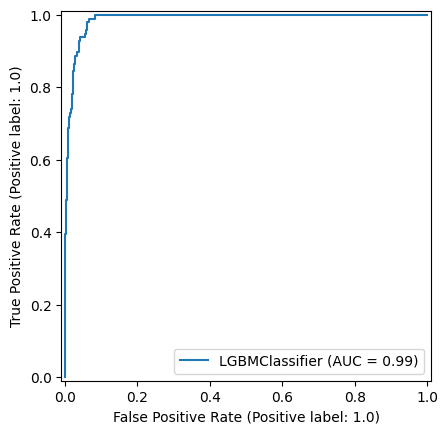

In [26]:
RocCurveDisplay.from_estimator(lgbm_clf, X_train, y_train)

0.9429530201342282
[0.99288256 0.11764706]


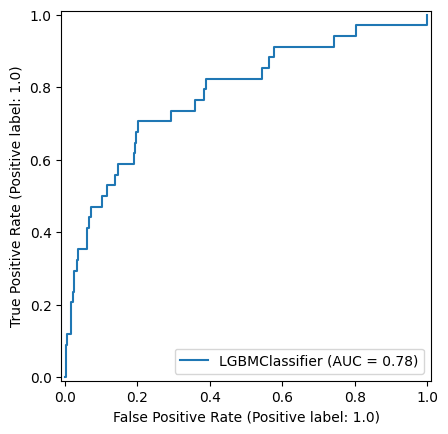

In [27]:
RocCurveDisplay.from_estimator(lgbm_clf, X_test, y_test)
# y_test: LABEL, y_test_pred: Prediction of classifier model
y_test_pred = lgbm_clf.predict(X_test)

print(accuracy_score(y_test,y_test_pred))
print(recall_score(y_test,y_test_pred,average=None))

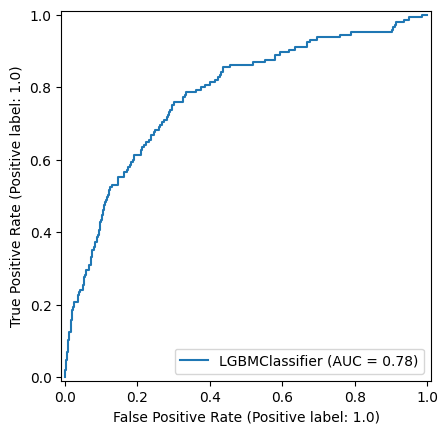

In [28]:
RocCurveDisplay.from_estimator(lgbm_clf, ext_X, ext_y)

In [29]:
lgbm_reg = LGBMRegressor(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_reg.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 13
[LightGBM] [Info] Start training from score 0.069164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(boosting_type='dart', learning_rate=0.01, n_estimators=500)

### Save test sets and results to CSV

In [30]:
### Due to random samples, indices are shuffled-> reorganize sample orders and run the prediction -> save to csv
attr_x = X_test.columns
row_num = y_test.index  # 환자 번호 (CSV 파일에서 no.)
Xt = np.moveaxis(np.array(X_test.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(Xt.shape[0]):
    if ii == 0:
        x_test_re = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
    else:
        tmp = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
        x_test_re = x_test_re.join(tmp)
# x_test_re: 재배열된 X_test

# [HCC, name, ID] DataFrame을 생성한다
gt =  pd.DataFrame({'HCC':np.array(y_test.values.tolist())})
name = pd.DataFrame({'Name':np.array(HepatitisC_all['name'][row_num].values.tolist())})
ID = pd.DataFrame({'ID':np.array(HepatitisC_all['ID'][row_num].values.tolist()).astype(np.uint64)})

In [31]:
y_test_pred = lgbm_reg.predict(x_test_re)
# np.maximum(A, B, C, ...): A, B, C, ...를 element-wise하게 비교해서 최대값 반환
y_test_pred_GB = np.maximum(y_test_pred,0)  # y_test_pred와 0을 비교한 최대값 --> 0보다 작은 값은 모두 0으로 반환 (ReLU와 비슷한 효과)

pred = pd.DataFrame({'LGBM':np.array(y_test_pred_GB)})
results = ID.join(name)
results = results.join(x_test_re)
results = results.join(gt)
results = results.join(pred)
print(results)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Gradient_Boosting.csv', index=False)
# results.to_excel('Results_Gradient_Boosting.xlsx', index=False)

           ID  Name  Age0  Gender  Platelet0  AST0  ALT0  Bilirubin0  \
0      322709   권상순  59.0     1.0      219.0  15.0  14.0         0.7   
1     3555929   전*순  68.0     1.0      393.0  14.0  10.0         0.2   
2     1025449   장정자  69.0     1.0      112.0  30.0  30.0         1.0   
3      477715   박정자  74.0     1.0      130.0  54.0  18.0         0.6   
4     2728204   이지영  46.0     1.0      154.0  19.0  12.0         0.5   
..        ...   ...   ...     ...        ...   ...   ...         ...   
591    423836   허금덕  62.0     1.0      181.0  39.0  57.0         0.5   
592   2264954  제갈은정  44.0     1.0      290.0  16.0  14.0         0.4   
593   1470238   김덕순  66.0     1.0       56.0  24.0  16.0         1.5   
594   2437732   정정숙  46.0     1.0      312.0  44.0  54.0         0.5   
595  11144084   김○식  47.0     0.0      162.0  40.0  43.0         0.6   

     Albumin0  Age48  Platelet48  AST48  ALT48  Bilirubin48  Albumin48  HCC  \
0         3.8   60.0       277.0   17.0   15.0          

In [32]:
train_idx = X_train.index
test_idx = X_test.index
ext_idx = ext_X.index

internal_ID = []
external_ID = []
for i in train_idx:
    internal_ID.append(HepatitisC_all["ID"][i])
for j in test_idx:
    internal_ID.append(HepatitisC_all["ID"][j])
for k in ext_idx:
    external_ID.append(ext_val_all["ID"][k])

train_out = lgbm_clf.predict_proba(X_train)[:,1]
test_out = lgbm_clf.predict_proba(X_test)[:,1]
ext_out = lgbm_clf.predict_proba(ext_X)[:,1]

internal_excel = pd.DataFrame({"ID": internal_ID,
                            "LGBM": list(train_out) + list(test_out)})
external_excel = pd.DataFrame({"ID": external_ID,
                               "LGBM": list(ext_out)})

print(internal_excel)
print(external_excel)

            ID      LGBM
0       821505  0.070598
1       245503  0.103052
2      2248690  0.070859
3      3063063  0.114244
4      2728281  0.070755
...        ...       ...
1979    423836  0.071404
1980   2264954  0.070689
1981   1470238  0.291766
1982   2437732  0.070734
1983  11144084  0.069911

[1984 rows x 2 columns]
             ID      LGBM
0       8095788  0.145170
1        603254  0.250083
2       7784929  0.100358
3       8376770  0.317877
4       7525004  0.645797
...         ...       ...
5306  238095298  0.071036
5307  237378012  0.132727
5308  204203618  0.129716
5309  218696498  0.068818
5310  241393107  0.070774

[5311 rows x 2 columns]


In [33]:
thresholds = np.linspace(0.01,0.13,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_GB.shape),dtype = float)
    y_pred[y_test_pred>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.01       0.02333333 0.03666667 0.05       0.06333333 0.07666667
 0.09       0.10333333 0.11666667 0.13      ]
Confusion matrix: threshold - 0.010
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.45   |   0.55   | 
E  1 |    0.09   |   0.91   | 
Confusion matrix: threshold - 0.023
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.58   |   0.42   | 
E  1 |    0.18   |   0.82   | 
Confusion matrix: threshold - 0.037
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.69   |   0.31   | 
E  1 |    0.24   |   0.76   | 
Confusion matrix: threshold - 0.050
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.29   |   0.71   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.35   |   0.65   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 
R    |     N     |  

In [34]:
Feature_importance = pd.DataFrame({'Feature':X_train.columns,'Importance':lgbm_reg.feature_importances_})
Feature_importance = Feature_importance.sort_values(by='Importance',ascending=False)
Feature_importance = Feature_importance.set_index('Feature')

Feature_importance

,Importance
Feature,
Platelet0,2625
ALT0,1648
AST0,1645
Platelet48,1523
Age0,1471
Albumin0,1381
AST48,1346
ALT48,1149
Bilirubin48,803


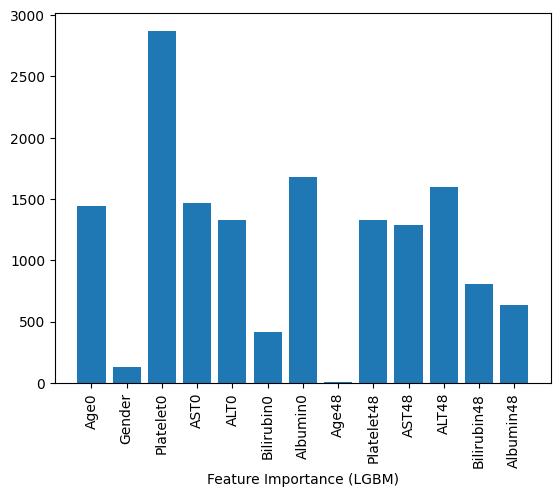

In [35]:
features = X_train.columns
importances = lgbm_clf.feature_importances_

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Feature Importance (LGBM)')
plt.show()

## 2. Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtree_clf = DecisionTreeClassifier()
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[5,10,15,20]}  # 이 parameter들을 dtree_clf에 입력해서 그 중의 최적의 parameter를 찾는다

dt_clf_GS = GridSearchCV(dtree_clf, parameters, cv=5)  # cv: Cross-Validation
dt_clf_GS.fit(X_train, y_train)
# dt_clf_GS.best_params_: 최적의 parameter 반환
# dt_clf_GS.best_score_: 가장 높은 성능 반환
# dt_clf_GS.best_estimator: 최적의 parameter로 RE-Trained된 estimator 모델
# dt_clf_GS.classes_: 무슨 classes를 반환하는가?

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [37]:
# dt_clf_GS.predict_proba(X: array-like) -> 무슨 확률을 예측?
print('Train AUC-ROC score is', roc_auc_score(y_train, dt_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, dt_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.8342161700206397
Test AUC-ROC score is 0.7650983881096922


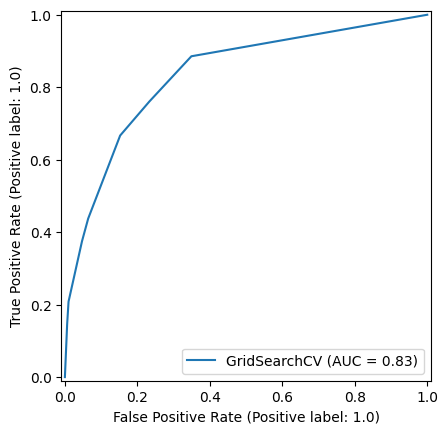

In [38]:
RocCurveDisplay.from_estimator(dt_clf_GS, X_train, y_train)

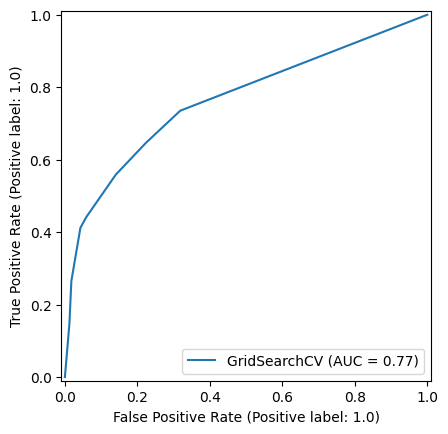

In [39]:
RocCurveDisplay.from_estimator(dt_clf_GS,X_test,y_test)  # .best_estimator_ 메소드 없이도 자동으로 최적의 parameter로 재학습한 estimator를 사용하는가?

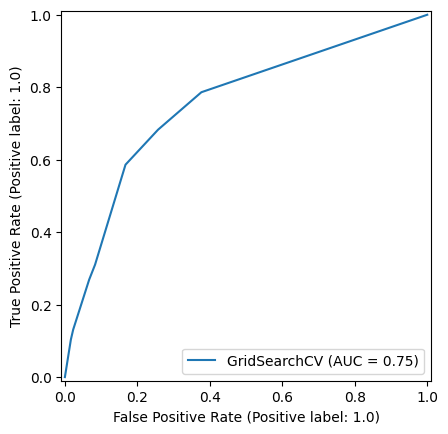

In [40]:
RocCurveDisplay.from_estimator(dt_clf_GS, ext_X, ext_y)

In [41]:
dtree_reg = DecisionTreeRegressor()
dt_reg_GS = GridSearchCV(dtree_reg, parameters, cv=5)
dt_reg_GS.fit(X_train, y_train)

y_test_pred = dt_reg_GS.predict(x_test_re)
y_test_pred_DT = np.maximum(y_test_pred, 0)

pred = pd.DataFrame({'D_Tree':np.array(y_test_pred_DT)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Decision_Tree.csv', index=False)
# results.to_excel('Results_Decision_Tree.xlsx', index=False)

thresholds = np.linspace(0.03,0.07,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred.shape),dtype = float)  # y_pred: 크기 (645,)의 ndarray
    y_pred[y_test_pred>th] = 1  # Prediction이 threshold보다 큰 경우에만 1로 예측 (threshold보다 낮으면 0으로 예측)
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.03       0.03444444 0.03888889 0.04333333 0.04777778 0.05222222
 0.05666667 0.06111111 0.06555556 0.07      ]
Confusion matrix: threshold - 0.030
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.26   |   0.74   | 
Confusion matrix: threshold - 0.034
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.26   |   0.74   | 
Confusion matrix: threshold - 0.039
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.26   |   0.74   | 
Confusion matrix: threshold - 0.043
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.26   |   0.74   | 
Confusion matrix: threshold - 0.048
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.26   |   0.74   | 
Confusion matrix: threshold - 0.052
T    |      Prediction      | 
R    |     N     |  

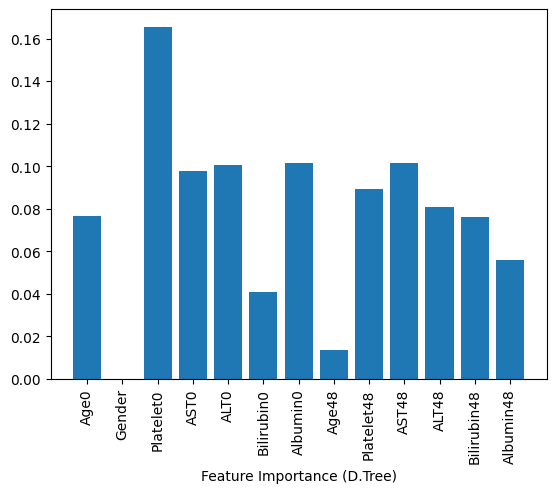

In [42]:
dtree_reg.fit(X_train, y_train)
importances = dtree_reg.feature_importances_

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Feature Importance (D.Tree)')
plt.show()

In [43]:
train_idx = X_train.index
test_idx = X_test.index
ext_idx = ext_X.index

train_out = dt_clf_GS.predict_proba(X_train)[:,1]
test_out = dt_clf_GS.predict_proba(X_test)[:,1]
ext_out = dt_clf_GS.predict_proba(ext_X)[:,1]

internal_excel["D_Tree"] = list(train_out) + list(test_out)
external_excel["D_Tree"] = list(ext_out)

print(internal_excel)
print(external_excel)

            ID      LGBM    D_Tree
0       821505  0.070598  0.012911
1       245503  0.103052  0.074074
2      2248690  0.070859  0.012911
3      3063063  0.114244  0.012911
4      2728281  0.070755  0.012911
...        ...       ...       ...
1979    423836  0.071404  0.012911
1980   2264954  0.070689  0.012911
1981   1470238  0.291766  0.161765
1982   2437732  0.070734  0.012911
1983  11144084  0.069911  0.012911

[1984 rows x 3 columns]
             ID      LGBM    D_Tree
0       8095788  0.145170  0.074074
1        603254  0.250083  0.074074
2       7784929  0.100358  0.074074
3       8376770  0.317877  0.250000
4       7525004  0.645797  0.545455
...         ...       ...       ...
5306  238095298  0.071036  0.012911
5307  237378012  0.132727  0.079646
5308  204203618  0.129716  0.079646
5309  218696498  0.068818  0.012911
5310  241393107  0.070774  0.012911

[5311 rows x 3 columns]


## 3. Random Forest

In [44]:
forest_clf = RandomForestClassifier()
parameters = {'max_depth':[3,5,7,9], 'min_samples_leaf':[5,10,15,20]}

f_clf_GS = GridSearchCV(forest_clf, parameters, cv=3)
f_clf_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [ ]:
print('Train AUC-ROC score is', roc_auc_score(y_train, f_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, f_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.8889077012383901
Test AUC-ROC score is 0.8208603726187984


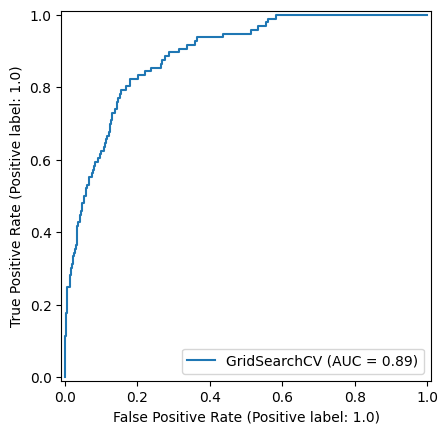

In [46]:
RocCurveDisplay.from_estimator(f_clf_GS, X_train, y_train)

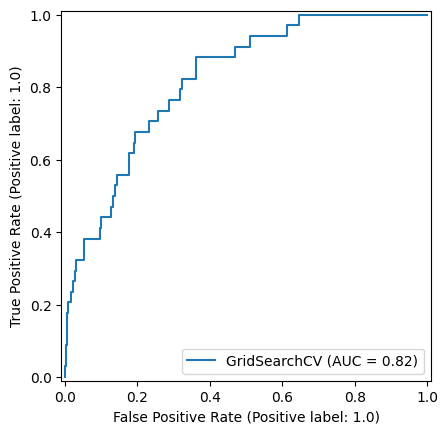

In [47]:
RocCurveDisplay.from_estimator(f_clf_GS,X_test,y_test)
y_test_pred_RF = f_clf_GS.predict_proba(x_test_re)[:, 1]

pred = pd.DataFrame({'Predition':np.array(y_test_pred_RF)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Random_Forest.csv', index=False)
# results.to_excel('Results_Random_Forest.xlsx', index=False)

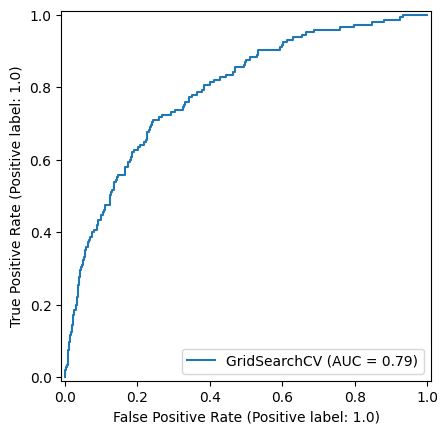

In [48]:
RocCurveDisplay.from_estimator(f_clf_GS, ext_X, ext_y)

In [49]:
thresholds = np.linspace(0.06,0.09,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_RF.shape),dtype = float)
    y_pred[y_test_pred_RF>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.3f   |   %.3f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.3f   |   %.3f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.06       0.06333333 0.06666667 0.07       0.07333333 0.07666667
 0.08       0.08333333 0.08666667 0.09      ]
Confusion matrix: threshold - 0.060
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.717   |   0.283   | 
E  1 |    0.265   |   0.735   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.728   |   0.272   | 
E  1 |    0.265   |   0.735   | 
Confusion matrix: threshold - 0.067
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.735   |   0.265   | 
E  1 |    0.265   |   0.735   | 
Confusion matrix: threshold - 0.070
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.747   |   0.253   | 
E  1 |    0.294   |   0.706   | 
Confusion matrix: threshold - 0.073
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.762   |   0.238   | 
E  1 |    0.294   |   0.706   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 


In [50]:
forest_clf.fit(X_train, y_train)
importances = forest_clf.feature_importances_

In [51]:
importances

array([0.06856644, 0.00890434, 0.13013477, 0.07388243, 0.07893037,
       0.06411715, 0.0897316 , 0.06398446, 0.10715142, 0.08072907,
       0.08427546, 0.06455912, 0.08503338])

In [52]:
sorted_indices = np.argsort(importances)[::-1]
sorted_indices

array([ 2,  8,  6, 12, 10,  9,  4,  3,  0, 11,  5,  7,  1], dtype=int64)

In [53]:
sorted_importance = importances[sorted_indices]
sorted_importance

array([0.13013477, 0.10715142, 0.0897316 , 0.08503338, 0.08427546,
       0.08072907, 0.07893037, 0.07388243, 0.06856644, 0.06455912,
       0.06411715, 0.06398446, 0.00890434])

In [54]:
sorted_feature = features[sorted_indices]
sorted_feature

Index(['Platelet0', 'Platelet48', 'Albumin0', 'Albumin48', 'ALT48', 'AST48',
       'ALT0', 'AST0', 'Age0', 'Bilirubin48', 'Bilirubin0', 'Age48', 'Gender'],
      dtype='object')

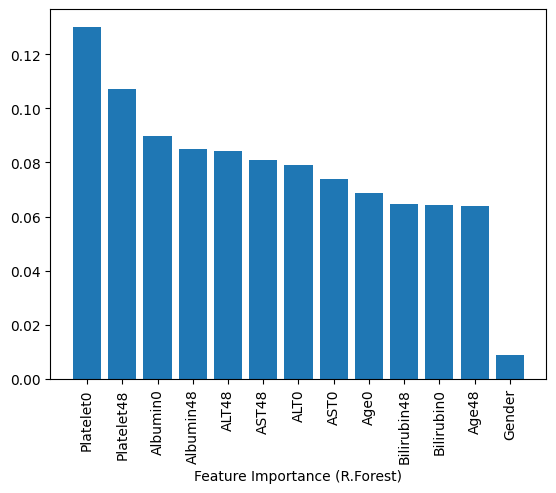

In [55]:
plt.bar(sorted_feature, sorted_importance)
plt.xticks(rotation=90)
plt.xlabel('Feature Importance (R.Forest)')
plt.show()

In [56]:
pred = pd.DataFrame({'R_Forest':np.array(y_test_pred_RF)})
results = results.join(pred)

In [57]:
results

,ID,Name,Age0,Gender,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,HCC,LGBM,D_Tree,R_Forest
0,322709,권상순,59.0,1.0,219.0,15.0,14.0,0.7,3.8,60.0,277.0,17.0,15.0,1.0,4.2,0.0,0.000990,0.074074,0.042593
1,3555929,전*순,68.0,1.0,393.0,14.0,10.0,0.2,4.2,69.0,232.0,20.0,16.0,0.5,4.4,0.0,0.015180,0.012911,0.028003
2,1025449,장정자,69.0,1.0,112.0,30.0,30.0,1.0,4.1,70.0,123.0,42.0,42.0,0.8,4.1,0.0,0.125399,0.079646,0.138342
3,477715,박정자,74.0,1.0,130.0,54.0,18.0,0.6,4.4,75.0,150.0,15.0,13.0,0.7,4.6,0.0,0.050798,0.012911,0.037506
4,2728204,이지영,46.0,1.0,154.0,19.0,12.0,0.5,3.9,47.0,173.0,16.0,12.0,0.7,4.3,0.0,0.018672,0.074074,0.036716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,423836,허금덕,62.0,1.0,181.0,39.0,57.0,0.5,4.6,63.0,144.0,18.0,10.0,0.3,5.2,0.0,0.025168,0.012911,0.021883
592,2264954,제갈은정,44.0,1.0,290.0,16.0,14.0,0.4,4.2,45.0,294.0,18.0,11.0,0.6,4.1,0.0,0.000000,0.012911,0.019984
593,1470238,김덕순,66.0,1.0,56.0,24.0,16.0,1.5,4.2,67.0,49.0,26.0,17.0,1.7,3.8,0.0,0.205897,0.161765,0.217431
594,2437732,정정숙,46.0,1.0,312.0,44.0,54.0,0.5,4.5,47.0,247.0,16.0,10.0,0.6,4.5,0.0,0.000000,0.012911,0.016052


In [58]:
train_idx = X_train.index
test_idx = X_test.index
ext_idx = ext_X.index

train_out = f_clf_GS.predict_proba(X_train)[:,1]
test_out = f_clf_GS.predict_proba(X_test)[:,1]
ext_out = f_clf_GS.predict_proba(ext_X)[:,1]

internal_excel["R_Forest"] = list(train_out) + list(test_out)
external_excel["R_Forest"] = list(ext_out)

print(internal_excel)
print(external_excel)

            ID      LGBM    D_Tree  R_Forest
0       821505  0.070598  0.012911  0.016441
1       245503  0.103052  0.074074  0.036192
2      2248690  0.070859  0.012911  0.045166
3      3063063  0.114244  0.012911  0.035757
4      2728281  0.070755  0.012911  0.018847
...        ...       ...       ...       ...
1979    423836  0.071404  0.012911  0.021883
1980   2264954  0.070689  0.012911  0.019984
1981   1470238  0.291766  0.161765  0.217431
1982   2437732  0.070734  0.012911  0.016052
1983  11144084  0.069911  0.012911  0.019993

[1984 rows x 4 columns]
             ID      LGBM    D_Tree  R_Forest
0       8095788  0.145170  0.074074  0.132680
1        603254  0.250083  0.074074  0.243035
2       7784929  0.100358  0.074074  0.167217
3       8376770  0.317877  0.250000  0.304891
4       7525004  0.645797  0.545455  0.399594
...         ...       ...       ...       ...
5306  238095298  0.071036  0.012911  0.025641
5307  237378012  0.132727  0.079646  0.125962
5308  204203618  0.12

In [59]:
INTERNAL_EXCEL = HepatitisC_all.merge(internal_excel, on="ID", how="left")
INTERNAL_EXCEL

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time,LGBM,D_Tree,R_Forest
0,913.0,3,2589876,김정숙,57.0,1,-1.0,0.0,1.0,-1.0,...,1.925426,45.21199,9.0,0,2105.0,0,2105.0,0.070690,0.012911,0.029716
1,558.0,1,3461912,조*호,50.0,0,0.0,0.0,0.0,8.5,...,-1.000000,-1.00000,-1.0,0,805.0,0,805.0,NaN,NaN,NaN
2,1783.0,4,375990,윤종숙,56.0,1,1.0,0.0,-1.0,8.8,...,1.722771,46.89670,10.0,0,919.0,0,919.0,0.070364,0.012911,0.019269
3,2301.0,5,10306121,송기영,85.0,1,1.0,0.0,-1.0,-1.0,...,2.810458,59.78904,14.0,0,648.0,1,648.0,0.086561,0.012911,0.073844
4,425.0,1,3334010,김*자,52.0,1,0.0,0.0,0.0,12.5,...,-1.000000,-1.00000,-1.0,0,385.0,0,385.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,1213.0,2,25983989,강현,43.0,1,-1.0,1.0,-1.0,-1.0,...,1.139510,-1.00000,-1.0,0,2627.0,0,2627.0,NaN,NaN,NaN
2817,438.0,1,3343560,윤*남,50.0,1,0.0,0.0,0.0,6.9,...,1.625204,44.31786,10.0,0,835.0,0,835.0,0.070369,0.012911,0.017725
2818,1290.0,2,22553026,노영,57.0,1,0.0,0.0,-1.0,6.1,...,-1.000000,-1.00000,-1.0,0,980.0,0,980.0,NaN,NaN,NaN
2819,624.0,1,6020561,권*미,46.0,1,0.0,0.0,0.0,4.0,...,-1.000000,-1.00000,-1.0,0,359.0,0,359.0,NaN,NaN,NaN


In [60]:
train_or_test = []
for _ in train_idx:
    train_or_test.append("Train")
for _ in test_idx:
    train_or_test.append("Test")

train_or_test = pd.DataFrame({"ID": internal_ID,
                              "Train/Test": train_or_test})

INTERNAL_FINAL_EXCEL = INTERNAL_EXCEL.merge(train_or_test, on="ID", how="left")
INTERNAL_FINAL_EXCEL

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time,LGBM,D_Tree,R_Forest,Train/Test
0,913.0,3,2589876,김정숙,57.0,1,-1.0,0.0,1.0,-1.0,...,45.21199,9.0,0,2105.0,0,2105.0,0.070690,0.012911,0.029716,Test
1,558.0,1,3461912,조*호,50.0,0,0.0,0.0,0.0,8.5,...,-1.00000,-1.0,0,805.0,0,805.0,NaN,NaN,NaN,NaN
2,1783.0,4,375990,윤종숙,56.0,1,1.0,0.0,-1.0,8.8,...,46.89670,10.0,0,919.0,0,919.0,0.070364,0.012911,0.019269,Train
3,2301.0,5,10306121,송기영,85.0,1,1.0,0.0,-1.0,-1.0,...,59.78904,14.0,0,648.0,1,648.0,0.086561,0.012911,0.073844,Train
4,425.0,1,3334010,김*자,52.0,1,0.0,0.0,0.0,12.5,...,-1.00000,-1.0,0,385.0,0,385.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,1213.0,2,25983989,강현,43.0,1,-1.0,1.0,-1.0,-1.0,...,-1.00000,-1.0,0,2627.0,0,2627.0,NaN,NaN,NaN,NaN
2833,438.0,1,3343560,윤*남,50.0,1,0.0,0.0,0.0,6.9,...,44.31786,10.0,0,835.0,0,835.0,0.070369,0.012911,0.017725,Train
2834,1290.0,2,22553026,노영,57.0,1,0.0,0.0,-1.0,6.1,...,-1.00000,-1.0,0,980.0,0,980.0,NaN,NaN,NaN,NaN
2835,624.0,1,6020561,권*미,46.0,1,0.0,0.0,0.0,4.0,...,-1.00000,-1.0,0,359.0,0,359.0,NaN,NaN,NaN,NaN


In [61]:
EXTERNAL_FINAL_EXCEL = ext_val_all.merge(external_excel, on="ID", how="left")
EXTERNAL_FINAL_EXCEL

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time,LGBM,D_Tree,R_Forest
0,1,1,8095788,-1.0,48.900000,1,1,-1.0,0.0,8.2,...,3.381609,65.082410,14.0,0,2237,0,2237,0.145170,0.074074,0.132680
1,2,1,603254,-1.0,79.600000,0,1,-1.0,0.0,-1.0,...,7.243432,73.385288,18.0,0,1149,0,1149,0.250083,0.074074,0.243035
2,3,1,7784929,-1.0,93.000000,0,1,-1.0,0.0,21.6,...,2.341913,72.025574,16.0,0,932,0,932,0.100358,0.074074,0.167217
3,4,1,8376770,-1.0,76.300000,0,0,-1.0,0.0,16.6,...,6.499159,74.530896,19.0,0,1827,0,1827,0.317877,0.250000,0.304891
4,6,1,7525004,-1.0,68.400000,1,0,-1.0,0.0,-1.0,...,8.623067,79.592614,18.0,0,1488,0,1488,0.645797,0.545455,0.399594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6632,7667,29,214679139,-1.0,53.520548,0,0,-1.0,0.0,5.1,...,1.136967,53.971462,9.0,0,1774,0,1774,NaN,NaN,NaN
6633,7668,29,218696498,-1.0,45.419178,1,0,-1.0,0.0,-1.0,...,0.944236,56.477349,9.0,0,2056,0,2056,0.068818,0.012911,0.028055
6634,7669,29,241393107,-1.0,33.098630,0,0,-1.0,0.0,-1.0,...,0.997685,45.210265,5.0,0,731,0,731,0.070774,0.012911,0.017411
6635,7671,29,221567888,-1.0,51.816438,0,0,-1.0,0.0,-1.0,...,-1.000000,-1.000000,-1.0,1,1308,0,1311,NaN,NaN,NaN


In [62]:
# INTERNAL_FINAL_EXCEL.to_excel("HCC_Prediction(Internal).xlsx", index=True)
# EXTERNAL_FINAL_EXCEL.to_excel("HCC_Prediction(External).xlsx", index=True)

## AUROC with 95% confidence interval

In [63]:
import sklearn.metrics
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

import calc_froc

In [64]:
from calc_froc import plot_roc_with_ci,plot_roc_with_ci

In [65]:
from typing import List, Tuple, Union, Any

In [66]:
def roc_with_ci(
    preds: np.array,
    labels: np.array,
    ci: float = 95,
    nbst: int = 1000,
    seed: Union[int, np.random.Generator] = None,
) -> dict:
    fprs, tprs, ths = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.auc(fprs, tprs)

    # bootstrap to get confidence interval
    tpr_bst_list = []
    auc_bst_list = []
    rng = np.random.default_rng(seed)
    for i in range(nbst):
        # sampling with replacement
        ind = rng.integers(0, len(labels), len(labels))
        label_bst = labels[ind]
        pred_bst = preds[ind]

        # calculate ROC for each bootstrap
        fpr_bst, tpr_bst, _ = sklearn.metrics.roc_curve(label_bst, pred_bst)

        # resample the roc for each fprs
        tpr_sample = np.interp(fprs, fpr_bst, tpr_bst)
        tpr_bst_list.append(tpr_sample)
        auc_bst_list.append(sklearn.metrics.auc(fpr_bst, tpr_bst))

    tpr_bst_list = np.array(tpr_bst_list)
    tprs_ci = np.percentile(tpr_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2], axis=0)
    auc_ci = np.percentile(auc_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2])

    return {
        'fprs': fprs,
        'tprs': tprs,
        'ths': ths,
        'tprs_ci': tprs_ci,
        'auc': auc,
        'auc_ci': auc_ci
    }

def roc_with_ci_draw(pred,gt,save_fig_name):
    results = roc_with_ci(np.array(pred),np.array(gt))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=300)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax = plot_roc_with_ci(
        ax, results['fprs'], results['tprs'], results['tprs_ci'], color=color, linestyle=linestyle
    )
    
    ax.set_xlabel('False positive')
    ax.set_ylabel('True positive')
    ax.grid(True)
    ax.set_xlim([-0.03, 1])
    ax.set_ylim([-0.03, 1.03])
    ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)
    # plt.savefig(save_fig_name)  # FROC plot 저장
    plt.show()

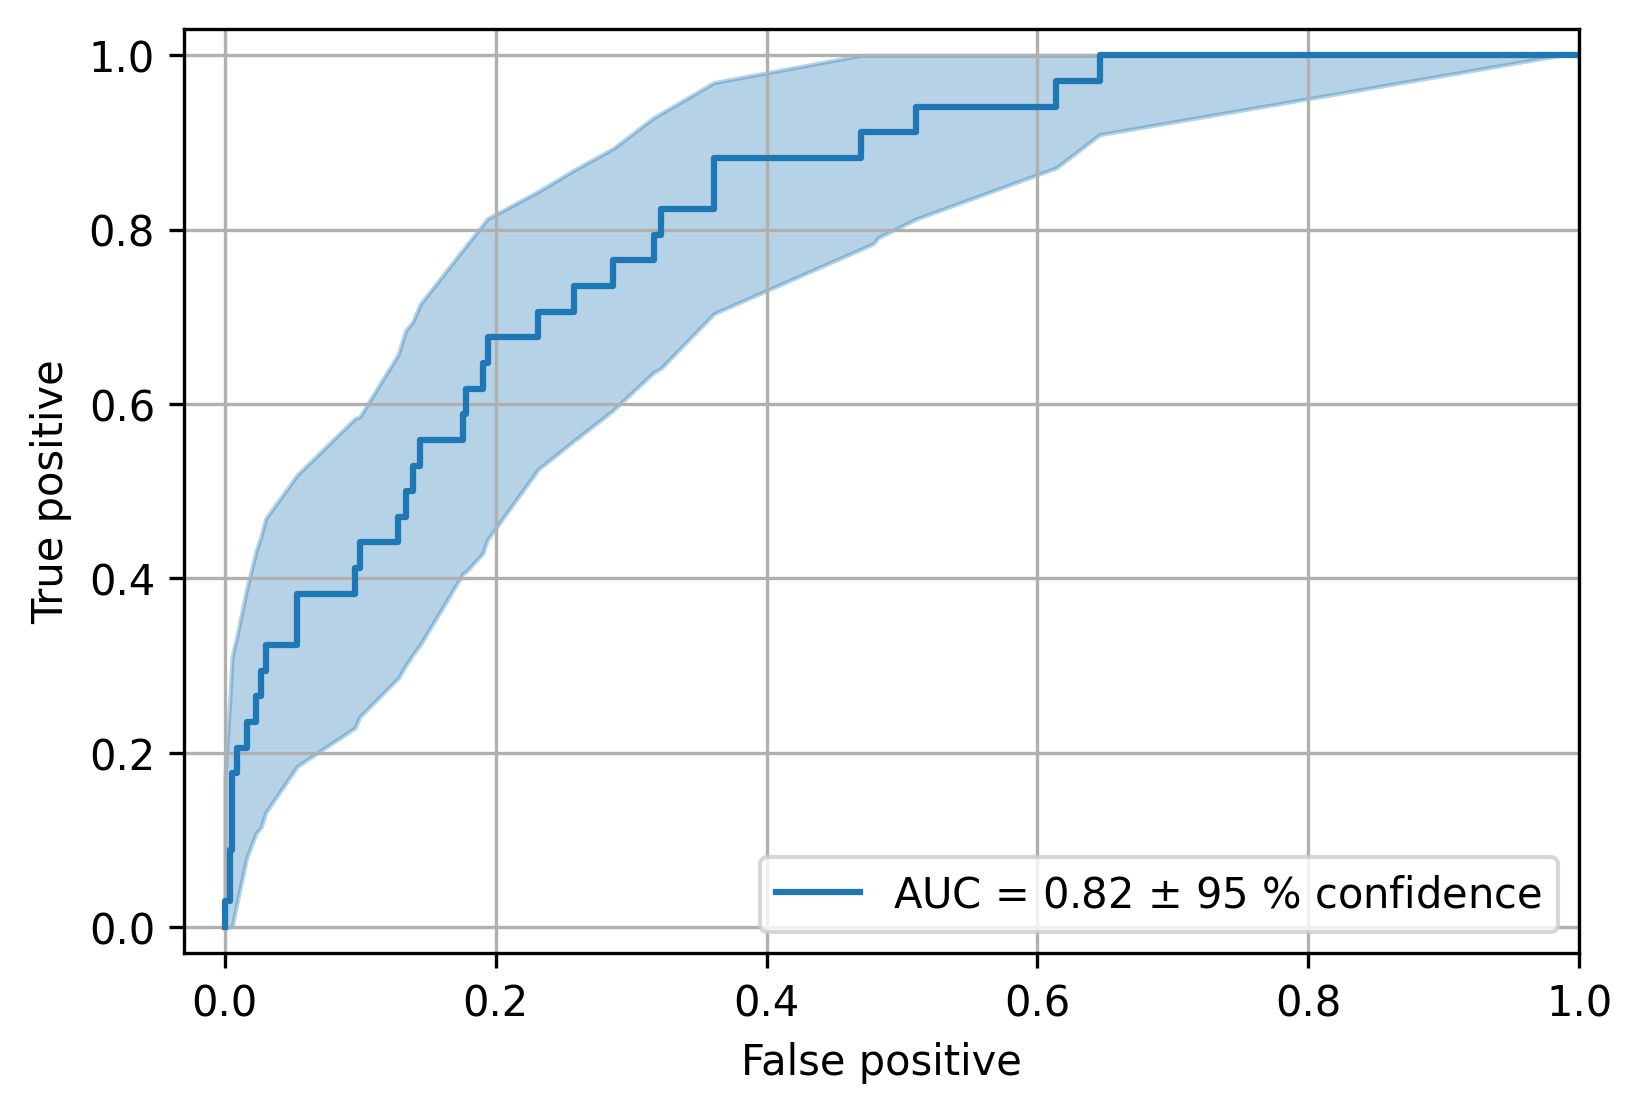

In [67]:
roc_with_ci_draw(y_test_pred_RF,gt,'RandomForest')

In [68]:
ext_gt =  pd.DataFrame({'HCC':np.array(ext_y.values.tolist())})

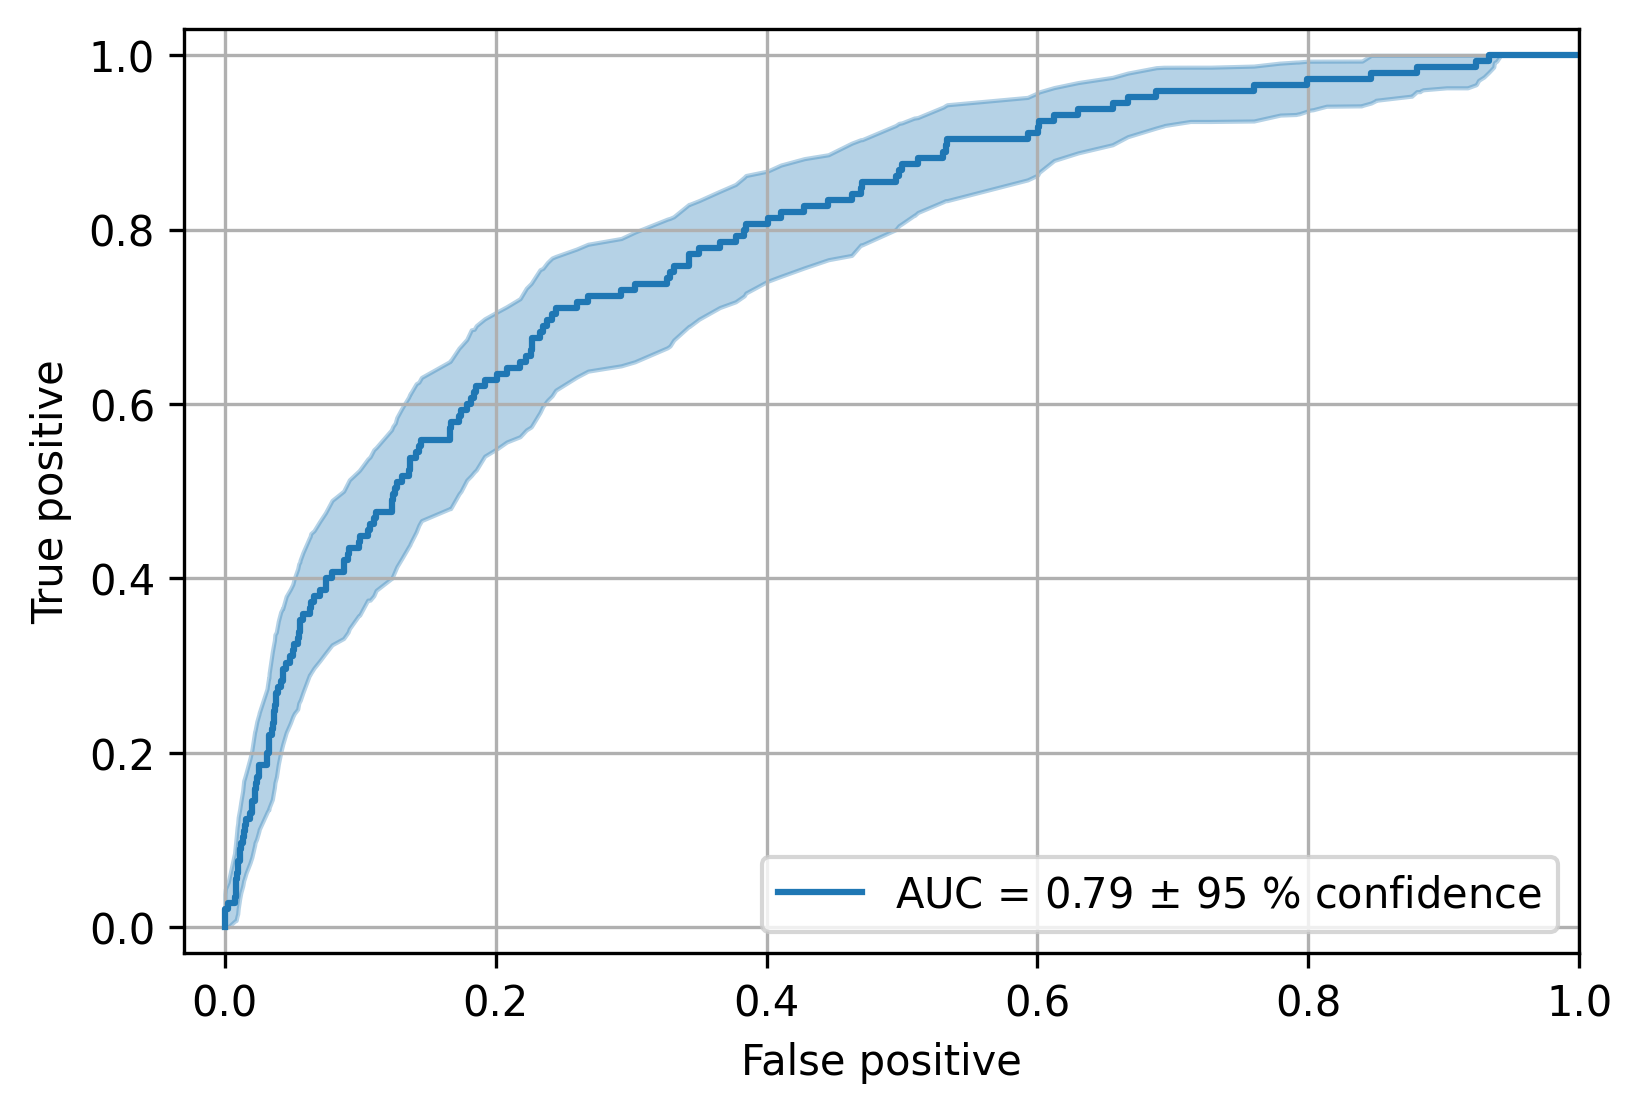

In [69]:
## External Validation 데이터로 신뢰구간 ROC 그리기 ###
ext_y_pred_RF = f_clf_GS.predict_proba(ext_X)[:, 1]
roc_with_ci_draw(ext_y_pred_RF, ext_gt, 'RandomForest')

# SHAP

In [70]:
import shap
from shap import summary_plot

c:\Users\PC00\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. LGBM

In [71]:
# explainer = shap.TreeExplainer(lgbm_clf)
# shap_values = explainer.shap_values(x_test_re)
# shap.summary_plot(shap_values, x_test_re)

## 2. Decision Tree

In [72]:
# dt_reg_est = dt_reg_GS.best_estimator_
# explainer = shap.TreeExplainer(dt_reg_est)
# shap_values = explainer.shap_values(x_test_re)
# shap.summary_plot(shap_values, x_test_re)

## 3. Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
f_reg_GS = GridSearchCV(forest_reg, parameters, cv=3)
f_reg_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

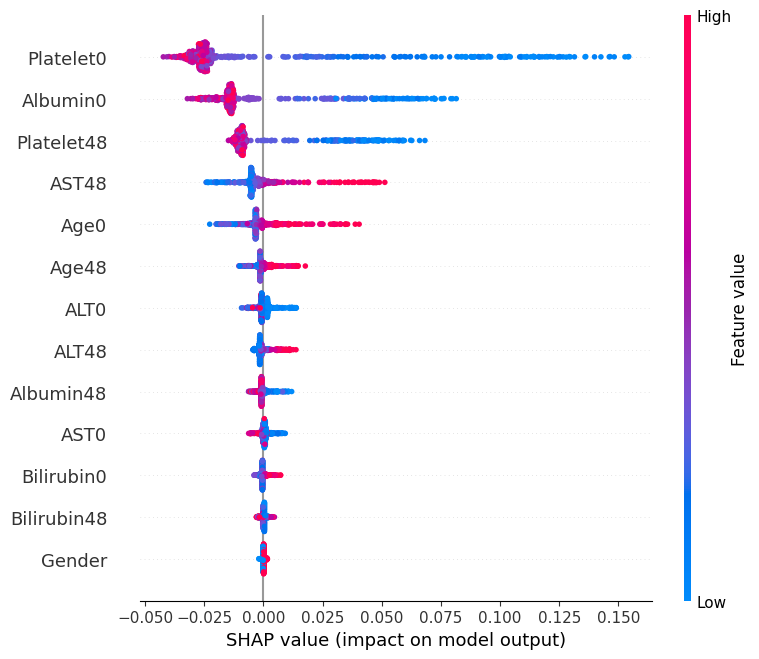

In [74]:
forest_est = f_reg_GS.best_estimator_
explainer = shap.TreeExplainer(forest_est)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re, show=True)

# ax = plt.gca()
# ax.set_yticklabels(["AST_base", "Bilirubin_1y", "ALT_base", "ALT_1y", "Albumin_1y", "Age_1y", "Bilirubin_base", "Age_base", "Platelet_1y", "AST_1y", "Platelet_base", "Albumin_base"])
# plt.show()